<a href="https://colab.research.google.com/github/k2345810/k2345810--Project-Dessertation/blob/main/Complex_Regularized_%26_Bidirectional_LSTM_Model_Model_with_KFold_Validation_codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Libraries
!pip install dask[complete]
!pip install imbalanced-learn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 1.8 MB/s eta 0:00:00


In [2]:
#Connecting to Google Drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [3]:
# Parallel Processing: Dask reads data in parallel, breaking it into smaller, manageable chunks, and then processes these
# chunks concurrently. This makes it possible to handle large datasets that
# don’t fit into memory.
import dask.dataframe as dd
file_path = '/content/drive/My Drive/CICIDS2018.csv'
ddf = dd.read_csv(file_path)

# Converting to Pandas DataFrame for processing
df = ddf.compute()

# Using 50% of the dataset
df = df.sample(frac=0.3, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
#feature reduction
# Encode the Label column
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Number of features before selection
print(f"Total features before selection: {df.shape[1] - 1}")

# Subsampling the data to make the calculation faster
sample_size = 200000
df_sample = df.sample(n=sample_size, random_state=42)

# Separate features and target for the subsample
X_sample = df_sample.drop('Label', axis=1)
y_sample = df_sample['Label']

# Train a RandomForest to get feature importances
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_sample, y_sample)
feature_importances = pd.Series(clf.feature_importances_, index=X_sample.columns)

# Sort features by importance
feature_importances = feature_importances.sort_values(ascending=False)
print("Feature importances from subsample:")
print(feature_importances)

# Select features with importance greater than a threshold
threshold = 0.01
selected_features = feature_importances[feature_importances > threshold].index
print(f"Selected Features: {selected_features}")

# Reduce full dataset to the selected features
df_reduced = df[selected_features.to_list() + ['Label']]

# Print total number of features after selection
print(f"Total features after selection: {df_reduced.shape[1] - 1}")  #exculding label columns

# Separate features and target for full dataset
X = df_reduced.drop('Label', axis=1)
y = df_reduced['Label']


Total features before selection: 78
Feature importances from subsample:
Init Fwd Win Byts    0.095170
Dst Port             0.081770
Fwd Seg Size Min     0.064813
Fwd Header Len       0.038531
Flow Pkts/s          0.038458
                       ...   
Fwd Byts/b Avg       0.000000
Bwd Byts/b Avg       0.000000
Fwd Blk Rate Avg     0.000000
Bwd Pkts/b Avg       0.000000
Bwd Blk Rate Avg     0.000000
Length: 78, dtype: float64
Selected Features: Index(['Init Fwd Win Byts', 'Dst Port', 'Fwd Seg Size Min', 'Fwd Header Len',
       'Flow Pkts/s', 'Flow IAT Min', 'Flow Duration', 'Flow IAT Max',
       'TotLen Fwd Pkts', 'Fwd IAT Mean', 'Fwd Pkts/s', 'Flow IAT Mean',
       'Fwd IAT Tot', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Pkt Len Mean',
       'Fwd Seg Size Avg', 'Fwd Pkt Len Max', 'Subflow Fwd Byts', 'Bwd Pkts/s',
       'Init Bwd Win Byts', 'Subflow Fwd Pkts', 'Flow IAT Std', 'Flow Byts/s',
       'Pkt Len Max', 'Bwd Pkt Len Std', 'Bwd Pkt Len Mean'],
      dtype='object')
Total features 

In [5]:
# skiped as no missing values found
#threshold = len(df_reduced) * 0.5
#df_reduced = df_reduced.dropna(thresh=threshold, axis=1)
#df_reduced = df_reduced.fillna(df_reduced.median())

# Separated features and target after handling missing values
X = df_reduced.drop('Label', axis=1)
y = df_reduced['Label']

In [6]:
# Normalize/Standardize Numerical Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Original number of features: 27
Reduced number of features after PCA: 11
Class distribution before handling imbalance:
Label
0     1338539
4       69002
6       57624
8       46247
1       28589
11      19494
14      18915
12      15965
9       13800
7        4152
10       1121
5         194
2          50
3          17
13          9
Name: count, dtype: int64
Class distribution after handling imbalance:
Label
0     1338539
11    1338539
7     1338539
4     1338539
8     1338539
6     1338539
14    1338539
1     1338539
9     1338539
12    1338539
5     1338539
10    1338539
3     1338539
2     1338539
13    1338539
Name: count, dtype: int64


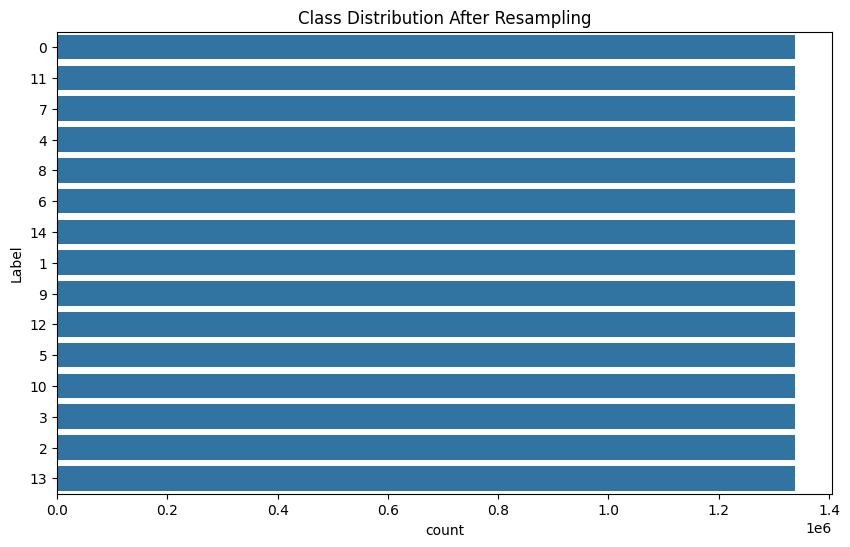

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

#PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Original number of features: {X_scaled.shape[1]}")
print(f"Reduced number of features after PCA: {X_pca.shape[1]}")

# Before handling class imbalance
print("Class distribution before handling imbalance:")
print(y.value_counts())

# Handling class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

# After handling class imbalance
print("Class distribution after handling imbalance:")
print(pd.Series(y_resampled).value_counts())

# Visualize class distribution after resampling
plt.figure(figsize=(10, 6))
sns.countplot(y=y_resampled, order=pd.Series(y_resampled).value_counts().index)
plt.title('Class Distribution After Resampling')
plt.show()


###Complex_Regularized_Model_with_KFold_Validation

Epoch 1/20
470849/470857 [============================>.] - ETA: 0s - loss: 0.3843 - accuracy: 0.8555
Epoch 1: val_loss improved from inf to 0.33804, saving model to best_model_fold1.keras
470857/470857 [==============================] - 1964s 4ms/step - loss: 0.3843 - accuracy: 0.8555 - val_loss: 0.3380 - val_accuracy: 0.8641 - lr: 0.0010
Epoch 2/20
470850/470857 [============================>.] - ETA: 0s - loss: 0.3662 - accuracy: 0.8577
Epoch 2: val_loss improved from 0.33804 to 0.32260, saving model to best_model_fold1.keras
470857/470857 [==============================] - 1900s 4ms/step - loss: 0.3662 - accuracy: 0.8577 - val_loss: 0.3226 - val_accuracy: 0.8674 - lr: 0.0010
Epoch 3/20
470850/470857 [============================>.] - ETA: 0s - loss: 0.3656 - accuracy: 0.8572
Epoch 3: val_loss improved from 0.32260 to 0.32025, saving model to best_model_fold1.keras
470857/470857 [==============================] - 1874s 4ms/step - loss: 0.3656 - accuracy: 0.8572 - val_loss: 0.3202 - 

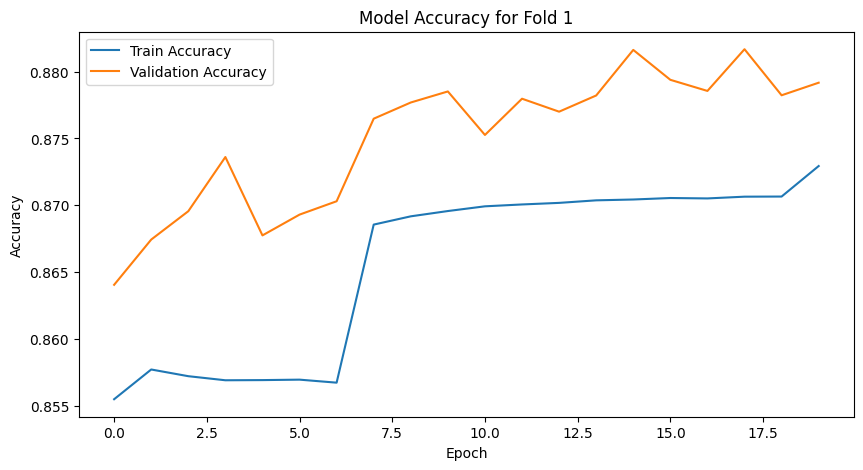

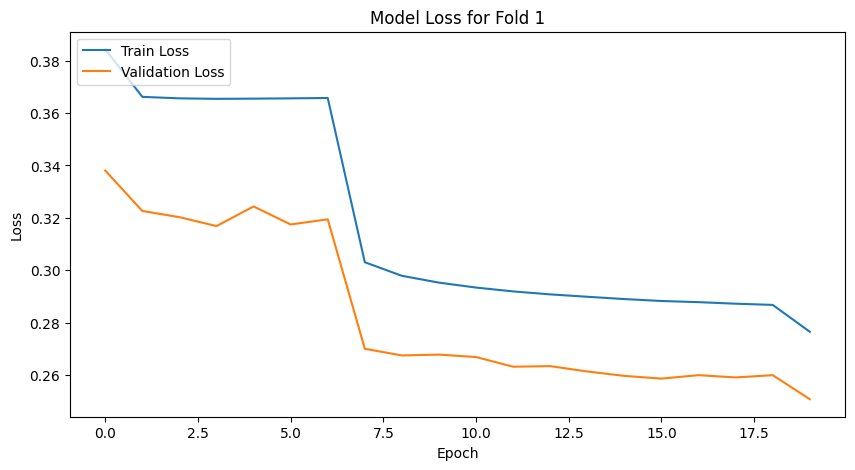

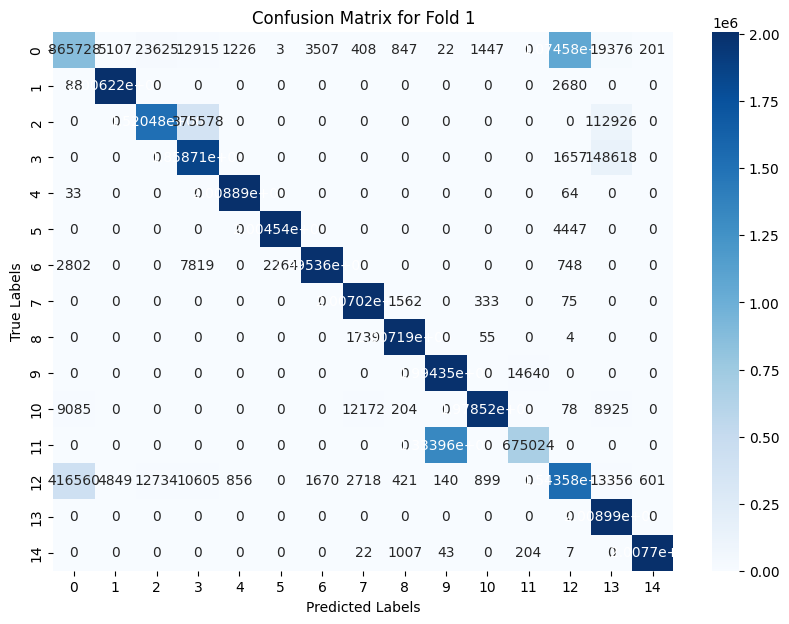

Epoch 1/20
470852/470857 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8561
Epoch 1: val_loss improved from inf to 0.35083, saving model to best_model_fold2.keras
470857/470857 [==============================] - 1957s 4ms/step - loss: 0.3833 - accuracy: 0.8561 - val_loss: 0.3508 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 2/20
470840/470857 [============================>.] - ETA: 0s - loss: 0.3670 - accuracy: 0.8580
Epoch 2: val_loss improved from 0.35083 to 0.32287, saving model to best_model_fold2.keras
470857/470857 [==============================] - 1955s 4ms/step - loss: 0.3670 - accuracy: 0.8580 - val_loss: 0.3229 - val_accuracy: 0.8699 - lr: 0.0010
Epoch 3/20
470843/470857 [============================>.] - ETA: 0s - loss: 0.3659 - accuracy: 0.8578
Epoch 3: val_loss did not improve from 0.32287
470857/470857 [==============================] - 1949s 4ms/step - loss: 0.3659 - accuracy: 0.8578 - val_loss: 0.3237 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 4/20

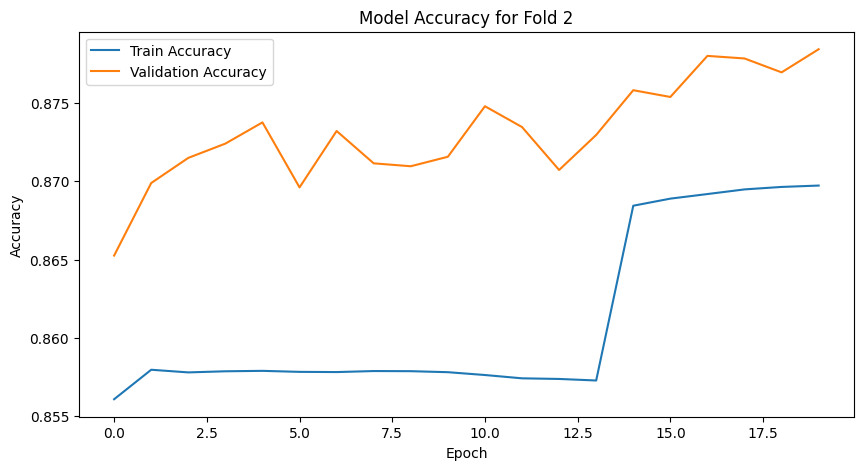

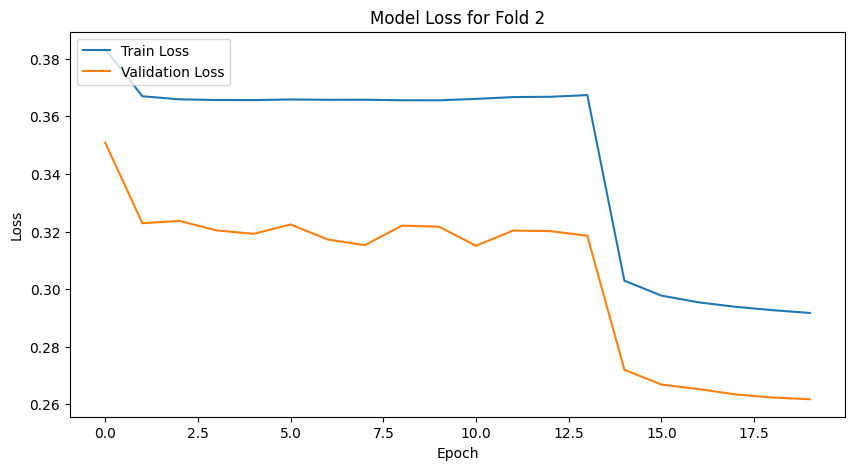

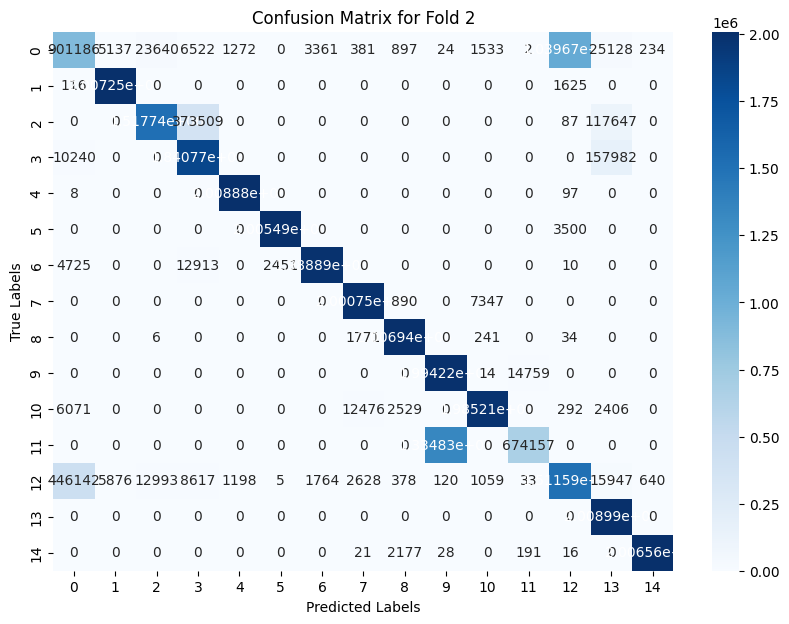

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.2503562867641449 - Accuracy: 87.94966340065002% - Precision: 0.8985275120038203 - Recall: 0.8787942984228876 - F1 Score: 0.8709789642021755 - ROC-AUC: 0.9350683741551185
------------------------------------------------------------------------
> Fold 2 - Loss: 0.2614010274410248 - Accuracy: 87.87177205085754% - Precision: 0.8972829093231899 - Recall: 0.8780078327993995 - F1 Score: 0.8704959379475085 - ROC-AUC: 0.9346470532853925
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 87.91071772575378 (+- 0.038945674896240234)
> Loss: 0.25587865710258484
> Precision: 0.897905210663505
> Recall: 0.8784010656111436
> F1 Score: 0.870737451074842
> ROC-AUC: 0.9348577137202555
------------------------------------------------------------------------


In [ ]:
#Complex_Regularized_Model_with_KFold_Validation
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# K-fold cross-validation
num_folds = 2
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Storage for the fold results
fold_no = 1
acc_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_score_per_fold = []
roc_auc_per_fold = []
conf_matrices = []

for train, test in kfold.split(X_scaled, y_resampled):
    # Model architecture
    model = Sequential(name="Complex_Regularized_Model_with_KFold_Validation")
    model.add(Input(shape=(X_scaled.shape[1],)))
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(len(np.unique(y_resampled)), activation='softmax'))

    # Compile
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_model_fold{fold_no}.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

    # Fit data to model
    history = model.fit(X_scaled[train], y_resampled[train],
                        batch_size=64,
                        epochs=20,
                        verbose=1,
                        validation_data=(X_scaled[test], y_resampled[test]),
                        callbacks=[early_stopping, model_checkpoint, reduce_lr])

    # Generalization metrics
    scores = model.evaluate(X_scaled[test], y_resampled[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Prediction and scoring
    y_pred = np.argmax(model.predict(X_scaled[test]), axis=1)
    precision = precision_score(y_resampled[test], y_pred, average='weighted')
    recall = recall_score(y_resampled[test], y_pred, average='weighted')
    f1 = f1_score(y_resampled[test], y_pred, average='weighted')
    roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_resampled[test]), tf.keras.utils.to_categorical(y_pred), average='weighted')

    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_score_per_fold.append(f1)
    roc_auc_per_fold.append(roc_auc)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_resampled[test], y_pred)
    conf_matrices.append(conf_matrix)

    # Plotting training & validation accuracy values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy for Fold {fold_no}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plotting training & validation loss values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for Fold {fold_no}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Enhanced Confusion Matrix Visualization
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_resampled), yticklabels=np.unique(y_resampled))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Fold {fold_no}')
    plt.show()

    fold_no += 1

# Average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]} - F1 Score: {f1_score_per_fold[i]} - ROC-AUC: {roc_auc_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Precision: {np.mean(precision_per_fold)}')
print(f'> Recall: {np.mean(recall_per_fold)}')
print(f'> F1 Score: {np.mean(f1_score_per_fold)}')
print(f'> ROC-AUC: {np.mean(roc_auc_per_fold)}')
print('------------------------------------------------------------------------')


###Bidirectional LSTM Model

Training for fold 1 ...
Epoch 1/10
104572/104574 [============================>.] - ETA: 0s - loss: 0.2240 - accuracy: 0.8776
Epoch 1: val_loss improved from inf to 0.19147, saving model to best_lstm_model_fold1.keras
104574/104574 [==============================] - 1904s 18ms/step - loss: 0.2240 - accuracy: 0.8776 - val_loss: 0.1915 - val_accuracy: 0.8909 - lr: 5.0000e-04
Epoch 2/10
104571/104574 [============================>.] - ETA: 0s - loss: 0.1994 - accuracy: 0.8865
Epoch 2: val_loss improved from 0.19147 to 0.18730, saving model to best_lstm_model_fold1.keras
104574/104574 [==============================] - 1895s 18ms/step - loss: 0.1994 - accuracy: 0.8865 - val_loss: 0.1873 - val_accuracy: 0.8904 - lr: 5.0000e-04
Epoch 3/10
104571/104574 [============================>.] - ETA: 0s - loss: 0.1949 - accuracy: 0.8884
Epoch 3: val_loss improved from 0.18730 to 0.18336, saving model to best_lstm_model_fold1.keras
104574/104574 [==============================] - 1892s 18ms/step - los

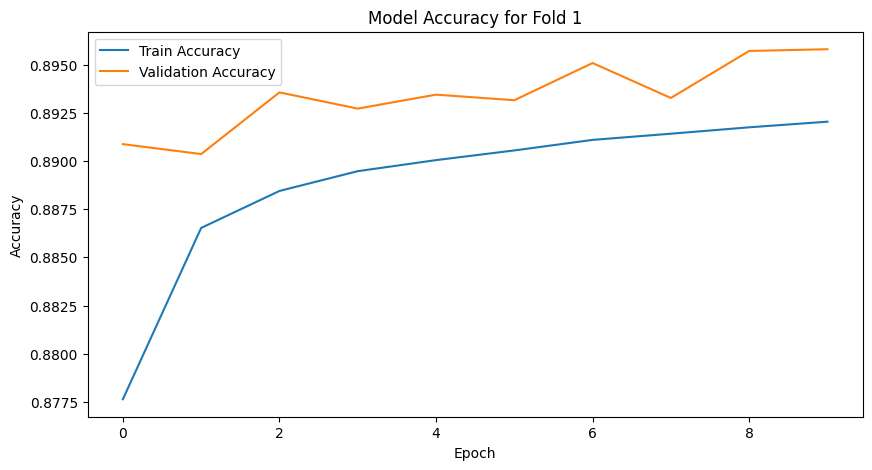

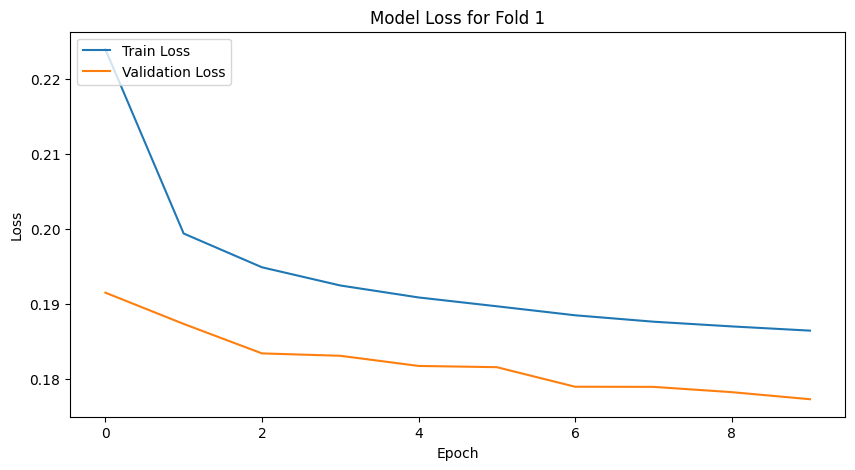

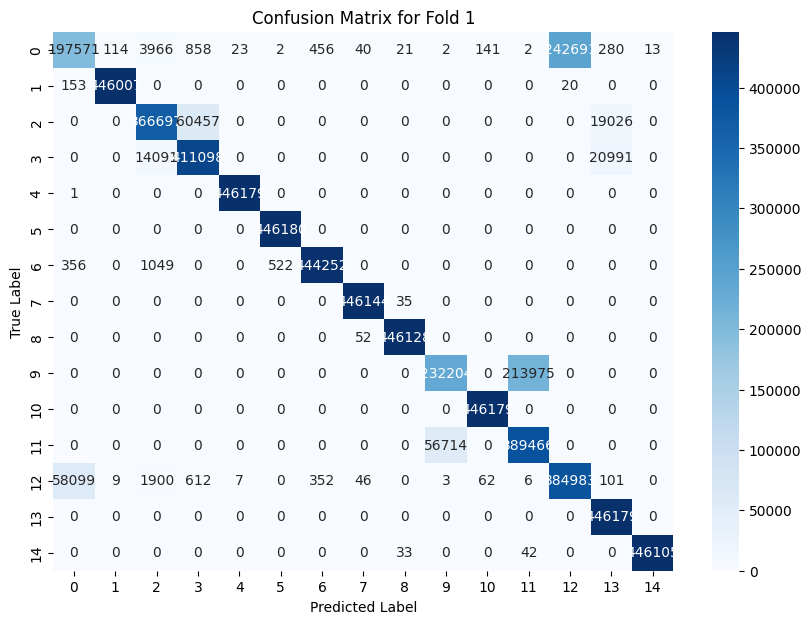

Training for fold 2 ...
Epoch 1/10
104572/104574 [============================>.] - ETA: 0s - loss: 0.2239 - accuracy: 0.8774
Epoch 1: val_loss improved from inf to 0.19479, saving model to best_lstm_model_fold2.keras
104574/104574 [==============================] - 1931s 18ms/step - loss: 0.2239 - accuracy: 0.8774 - val_loss: 0.1948 - val_accuracy: 0.8888 - lr: 5.0000e-04
Epoch 2/10
104571/104574 [============================>.] - ETA: 0s - loss: 0.2001 - accuracy: 0.8856
Epoch 2: val_loss improved from 0.19479 to 0.18689, saving model to best_lstm_model_fold2.keras
104574/104574 [==============================] - 1923s 18ms/step - loss: 0.2001 - accuracy: 0.8857 - val_loss: 0.1869 - val_accuracy: 0.8922 - lr: 5.0000e-04
Epoch 3/10
104571/104574 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.8883
Epoch 3: val_loss improved from 0.18689 to 0.18481, saving model to best_lstm_model_fold2.keras
104574/104574 [==============================] - 1923s 18ms/step - los

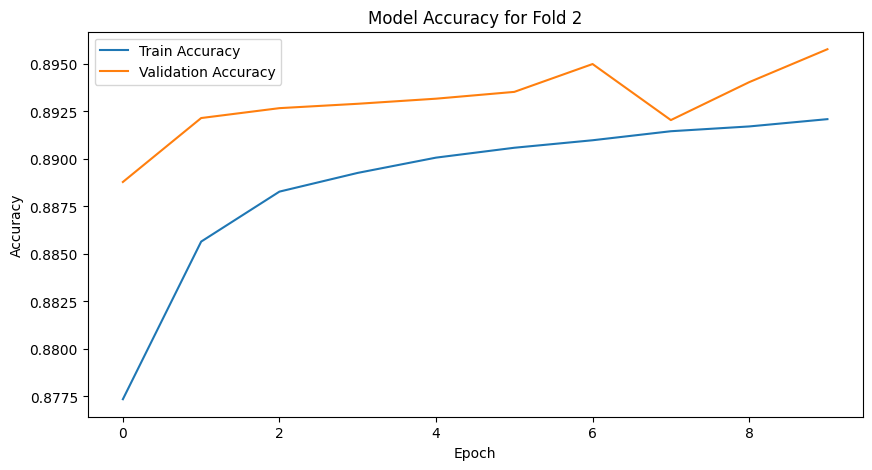

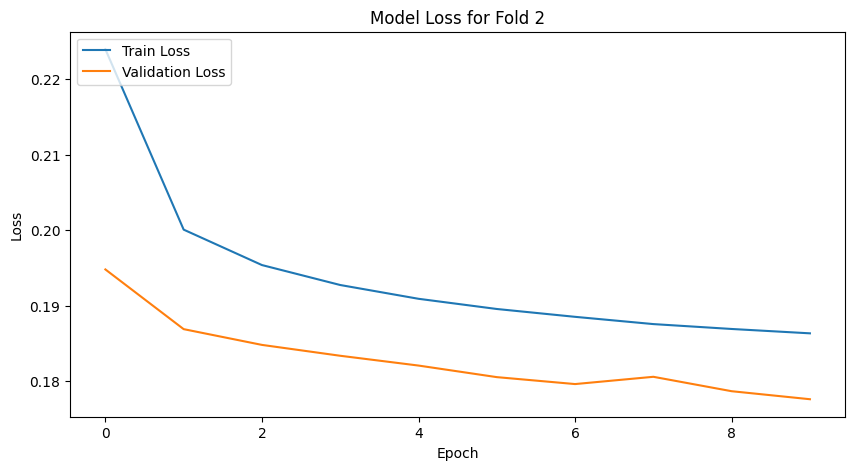

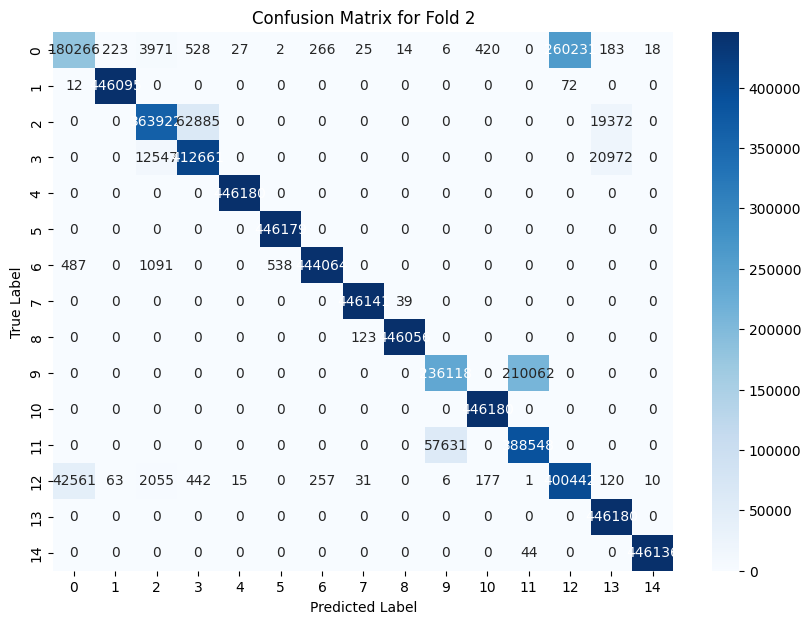

Training for fold 3 ...
Epoch 1/10
104573/104574 [============================>.] - ETA: 0s - loss: 0.2235 - accuracy: 0.8775
Epoch 1: val_loss improved from inf to 0.19184, saving model to best_lstm_model_fold3.keras
104574/104574 [==============================] - 1956s 19ms/step - loss: 0.2235 - accuracy: 0.8775 - val_loss: 0.1918 - val_accuracy: 0.8919 - lr: 5.0000e-04
Epoch 2/10
104571/104574 [============================>.] - ETA: 0s - loss: 0.1994 - accuracy: 0.8863
Epoch 2: val_loss improved from 0.19184 to 0.18623, saving model to best_lstm_model_fold3.keras
104574/104574 [==============================] - 1945s 19ms/step - loss: 0.1994 - accuracy: 0.8863 - val_loss: 0.1862 - val_accuracy: 0.8925 - lr: 5.0000e-04
Epoch 3/10
104572/104574 [============================>.] - ETA: 0s - loss: 0.1950 - accuracy: 0.8885
Epoch 3: val_loss improved from 0.18623 to 0.18488, saving model to best_lstm_model_fold3.keras
104574/104574 [==============================] - 1945s 19ms/step - los

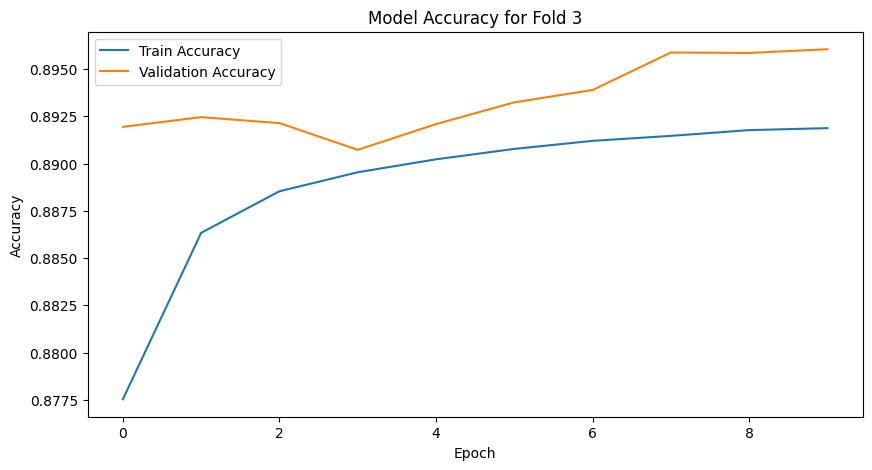

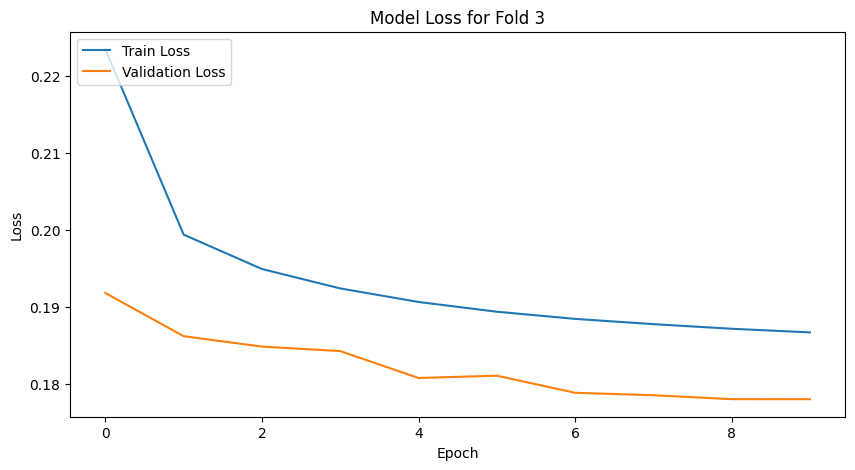

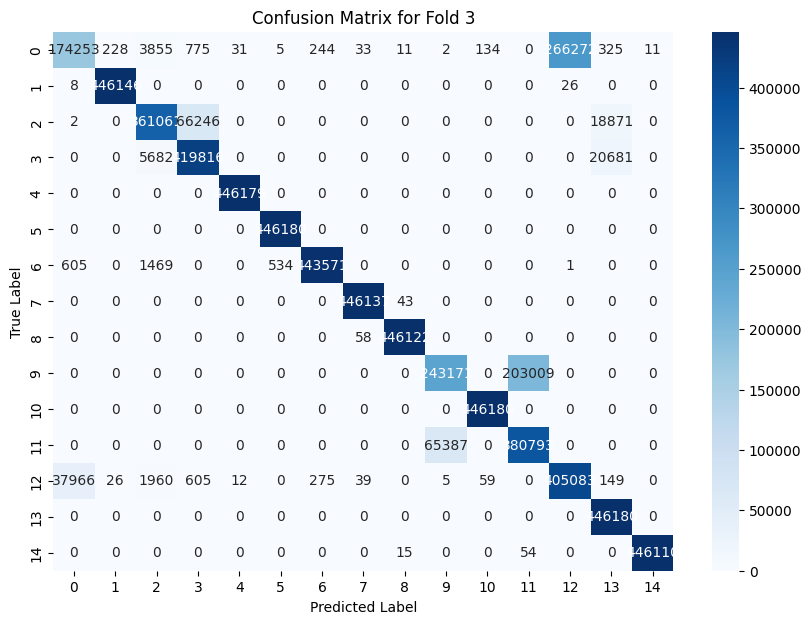

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.1772 - Accuracy: 89.58%
           Precision: 0.9041 - Recall: 0.8958
           F1 Score: 0.8920 - ROC-AUC: 0.9442
------------------------------------------------------------------------
> Fold 2 - Loss: 0.1776 - Accuracy: 89.58%
           Precision: 0.9061 - Recall: 0.8958
           F1 Score: 0.8911 - ROC-AUC: 0.9442
------------------------------------------------------------------------
> Fold 3 - Loss: 0.1780 - Accuracy: 89.60%
           Precision: 0.9068 - Recall: 0.8960
           F1 Score: 0.8913 - ROC-AUC: 0.9443
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 89.59% (+- 0.01%)
> Loss: 0.1776
> Precision: 0.9057
> Recall: 0.8959
> F1 Score: 0.8915
> ROC-AUC: 0.9442
------------------------------------------------------------------

In [8]:
#Bidirectional_LSTM_Model_with_KFold_Validation
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_resampled_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Initialize K-fold cross-validation
num_folds = 3
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Prepare storage for the fold results
fold_no = 1
acc_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_score_per_fold = []
roc_auc_per_fold = []
conf_matrices = []

for train, test in kfold.split(X_resampled_lstm, y_resampled):
    print(f'Training for fold {fold_no} ...')

    # Bidirectional LSTM model
    model = Sequential(name="Bidirectional_LSTM_Model_with_KFold_Validation")
    model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(X_resampled_lstm.shape[1], X_resampled_lstm.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(64))
    model.add(Dropout(0.4))
    model.add(Dense(len(np.unique(y_resampled)), activation='softmax'))

    # Compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  # Lowered learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_lstm_model_fold{fold_no}.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)

    # Training
    history = model.fit(X_resampled_lstm[train], y_resampled[train], epochs=10, batch_size=128,
                        validation_data=(X_resampled_lstm[test], y_resampled[test]),
                        callbacks=[early_stopping, model_checkpoint, reduce_lr])

    # Evaluation
    scores = model.evaluate(X_resampled_lstm[test], y_resampled[test], verbose=0)
    print(f'Score for fold {fold_no}: Accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Predictions
    y_pred = np.argmax(model.predict(X_resampled_lstm[test]), axis=1)

    # Metrics
    precision = precision_score(y_resampled[test], y_pred, average='weighted')
    recall = recall_score(y_resampled[test], y_pred, average='weighted')
    f1 = f1_score(y_resampled[test], y_pred, average='weighted')
    roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_resampled[test]), tf.keras.utils.to_categorical(y_pred), average='weighted', multi_class='ovr')

    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_score_per_fold.append(f1)
    roc_auc_per_fold.append(roc_auc)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_resampled[test], y_pred)
    conf_matrices.append(conf_matrix)

    # Plotting training & validation accuracy values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy for Fold {fold_no}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plotting training & validation loss values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for Fold {fold_no}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Enhanced Confusion Matrix Visualization
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_resampled), yticklabels=np.unique(y_resampled))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Fold {fold_no}')
    plt.show()

    fold_no += 1

# Summarize scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]:.4f} - Accuracy: {acc_per_fold[i]:.2f}%')
    print(f'           Precision: {precision_per_fold[i]:.4f} - Recall: {recall_per_fold[i]:.4f}')
    print(f'           F1 Score: {f1_score_per_fold[i]:.4f} - ROC-AUC: {roc_auc_per_fold[i]:.4f}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold):.2f}% (+- {np.std(acc_per_fold):.2f}%)')
print(f'> Loss: {np.mean(loss_per_fold):.4f}')
print(f'> Precision: {np.mean(precision_per_fold):.4f}')
print(f'> Recall: {np.mean(recall_per_fold):.4f}')
print(f'> F1 Score: {np.mean(f1_score_per_fold):.4f}')
print(f'> ROC-AUC: {np.mean(roc_auc_per_fold):.4f}')
print('------------------------------------------------------------------------')
